In [1]:
import pandas as pd 
import math
import numpy as np
from collections  import defaultdict
from sklearn.ensemble import RandomForestRegressor

#questions:
# what do we do with zeros and negative numbers bc you cant log() those nums? 
    #for right now if a num is greater than zero then it log() it
# are the given indexes the only ones using a percent unit ?
    #to modify just change the columns_to_exclude


#decentralized dataset
    # drops NaN
    # log tranfer everything but zeros and negatives
        #why log transfer and what does it do?
    # combine the nominal oil prices table with the macroeconomic features table 

#log transform can add more variability if there are outliers in data



the_table_path = 'Macroeconomic_Data.csv'
oil_factors_data = pd.read_csv(the_table_path)
print(oil_factors_data.head())

oil_price_path = 'csv_of_nominal_oil_prices.csv'
oil_price_data = pd.read_csv(oil_price_path)
oil_price_data.head() 



       date       RPI  W875RX1  DPCERA3M086SBEA   CMRMTSPLx      RETAILx  \
0  1/1/1986  6748.379   5932.0           47.357  665846.179  122987.5021   
1  2/1/1986  6781.198   5962.7           47.240  662058.599  121841.4787   
2  3/1/1986  6845.164   6018.8           47.401  662704.671  120996.2216   
3  4/1/1986  6868.394   6038.8           47.693  676048.783  121767.8428   
4  5/1/1986  6876.660   6043.6           47.980  669565.217  123536.1414   

    INDPRO  IPFPNSS  IPFINAL  IPCONGD  ...  DNDGRG3M086SBEA  DSERRG3M086SBEA  \
0  55.6511  63.3746  61.7948  72.9945  ...           54.821           45.557   
1  55.2700  62.7722  61.1830  72.3652  ...           54.327           45.768   
2  54.8828  62.5615  60.9771  72.1034  ...           53.380           45.968   
3  54.9456  62.7816  61.0642  72.5823  ...           52.747           46.051   
4  55.0535  62.9988  61.2052  72.9877  ...           52.861           46.110   

   CES0600000008  CES2000000008  CES3000000008  UMCSENTx  DTCO

,Date,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"
0,Jan-1986,22.93
1,Feb-1986,15.46
2,Mar-1986,12.61
3,Apr-1986,12.84
4,May-1986,15.38


In [2]:
def normalize_data_and_mod_interest_rates_in_table(data,columns_to_exclude,index_of_interest_rate):
    #converts dataframe to NumPy array
    array_data = data.to_numpy()
    
    total_rows, total_cols = array_data.shape
    
    for row in range(total_rows):
        
        #skip col 0 bc those are the dates
        for col in range(1,total_cols):
            
            #converting interest rates (percents) to decmial nums
            #comment this if statement to check if normalizing is correct or see if its just divided by 100 ( excluded the log but divided by 100) 
            if col in index_of_interest_rate:
                array_data[row][col] = array_data[row][col]/100
            
            if col in columns_to_exclude:
                continue
                
            #debugging print(array_data[row][col])
            #skipping negative nums for now    ************
            if array_data[row][col] > 0 :
                array_data[row][col] = math.log2(array_data[row][col])
                #print(math.log(array_data[row][col]))
                
    #doesnt modify the original table, ouputs a new modified table
    return array_data
        
            

In [3]:
index_of_interest_rates = [78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94]    
index_of_columns_to_exclude = [24,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94]
#inserting column names and normalizing data in table
normalized_table = np.insert(normalize_data_and_mod_interest_rates_in_table(oil_factors_data,index_of_columns_to_exclude,index_of_interest_rates),0,oil_factors_data.columns, axis= 0 )                                          
#converting from Numpy array to DataFrame
normalized_table = pd.DataFrame(normalized_table)


#debugging**** printing selected columns
selected_columns = normalized_table.loc[:,75:100]
print(selected_columns)
#normalized_table.head()

#debugging**** checking modified w original 
print("****** OG table below: ******")
c = oil_factors_data.iloc[:, 75:100+1]
print(c)


             75             76            77        78      79      80   \
0    S&P: indust  S&P div yield  S&P PE ratio  FEDFUNDS   CP3Mx   TB3MS   
1       7.847997       1.931169      3.707862    0.0814  0.0771  0.0707   
2       7.918267       1.862825      3.807316    0.0786  0.0763  0.0706   
3        8.00169       1.787613      3.915168    0.0748   0.072  0.0656   
4       8.043848        1.75743      3.970388    0.0699   0.066  0.0606   
..           ...            ...           ...       ...     ...     ...   
446    12.468418       0.732402      4.409011    0.0457  0.0474  0.0465   
447    12.446538       0.781368      4.387405    0.0465  0.0491  0.0469   
448    12.509327            NaN      4.454423    0.0483  0.0503  0.0492   
449     12.52692            NaN           NaN    0.0506  0.0515  0.0514   
450    12.604104            NaN           NaN    0.0508  0.0522  0.0516   

        81      82      83      84   ...     91       92      93      94   \
0     TB6MS     GS1   

In [4]:
def get_real_price_of_oil(nominal_oil_prices_with_dates_table, cpi_dates, cpi ):
    #have to match the month-year witht the selected cpi and price of oil 
    
    month_to_int = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}
    hashmap_oil_prices_with_dates = {}
    checking_set= set() 
    
    #converts dataframe to NumPy array
    array_oil_prices_dates = nominal_oil_prices_with_dates_table.to_numpy()
    total_rows, total_cols = array_oil_prices_dates.shape
    
    #going through the oil prices and dates
    #the dates are unique and contains no dups
    for row in range(total_rows):
        for col in range(total_cols):
            if col == 0 :
                #convert string month to int of the dates of oil prices 
                month_year = array_oil_prices_dates[row][col]
                month = month_to_int[month_year[:month_year.find("-")]]
                year = month_year[month_year.find("-")+1:]
                month_year_of_oil_prices = str(month)+ "-" + str(year)
            if col == 1:
                hashmap_oil_prices_with_dates[month_year_of_oil_prices] = array_oil_prices_dates[row][col]
    
    
    hashmap_cpi_dates_and_cpi = {}
    #going through the cpi dates and cpi nums and adding it to a hashmap
    #cpi dates are unique and contains no dups 
    for row in range(len(cpi_dates)):
        the_date = cpi_dates[row]
        new_formatted_date = str(the_date[:the_date.find("/")]+ "-"+ the_date[the_date.find("/",3)+1:])
        hashmap_cpi_dates_and_cpi[new_formatted_date] = cpi[row]
        
    #if hashmap_cpi_dates_and_cpi["dat-date"] == 'CPIAUCSL'   :
        #del hashmap_cpi_dates_and_cpi["dat-date"]

    # creating new table with the calculated real price of oil
    #cpi has 450 ( doesnt have 7-2023, ends on 6-2023) and oil prices has 451 (has 7-2023)

    list_of_real_oil_prices = []
    list_of_real_oil_prices.append("Real Oil Prices")

    for key , val in hashmap_oil_prices_with_dates.items():
            if key == "7-2023" :
                 continue
            real_oil_price = (hashmap_oil_prices_with_dates[key]/hashmap_cpi_dates_and_cpi[key]*100)
            list_of_real_oil_prices.append(real_oil_price)
    
    return list_of_real_oil_prices
 
        
    

In [5]:
#cpi was an integer but it is log transfered 
#if nom price / (cpi*100) 

print(get_real_price_of_oil(oil_price_data,normalized_table[0], normalized_table[105]))

['Real Oil Prices', 338.1982167936156, 228.11041146834648, 186.27648153880062, 189.82266294834352, 227.23967406881923, 198.27358983919402, 171.07548765794408, 222.84191663200548, 219.27755830948556, 219.6350680781092, 224.2655845198899, 237.1973059216001, 274.2806213198295, 260.8461911768531, 268.72527394691565, 274.04721369195323, 285.0365086771247, 293.9992301726797, 312.4287762577423, 297.0739491484202, 285.45446885575774, 290.11801714999496, 275.16242045277494, 252.1524308024466, 249.781969535501, 244.88131516051192, 236.00758572982906, 259.8638875619049, 253.32592263444863, 240.16936344726844, 225.00475689058334, 225.09659475834977, 210.69816886169588, 199.40084611466258, 204.6163760409678, 236.86670070309276, 260.35774902490175, 259.0239894033911, 280.9709749690716, 303.4410990425448, 289.4671775180493, 288.2669193651316, 284.1953234073688, 266.95394888316036, 281.325092205809, 288.36248471005683, 284.6848792457223, 302.26148192023453, 326.83507069477395, 315.85714285714283, 291.

In [6]:
#cpi:all items is an integer and no log transfered
#get_real_price_of_oil(oil_price_data,oil_factors_data['date'], oil_factors_data['CPIAUCSL'])    
#"""
normalized_table[127] =  get_real_price_of_oil(oil_price_data,oil_factors_data['date'], oil_factors_data['CPIAUCSL'])
normalized_table = normalized_table.dropna()
normalized_table = normalized_table.reset_index(drop=True)
normalized_table.tail()
normalized_table_to_csv = normalized_table.to_csv("macro_features_and_real_oil_prices_log_tranferred_dropped_Nan_skipped_neg_and_zeros_for_log.csv", index = True)

#"""
normalized_table = pd.read_csv("macro_features_and_real_oil_prices_log_tranferred_dropped_Nan_skipped_neg_and_zeros_for_log.csv")

1       2/1/1992
2       3/1/1992
3       4/1/1992
4       5/1/1992
5       6/1/1992
         ...    
369    11/1/2022
370    12/1/2022
371     1/1/2023
372     2/1/2023
373     3/1/2023
Name: 0, Length: 373, dtype: object
[0]	validation_0-rmsle:2.65592	validation_1-rmsle:2.64619
[1]	validation_0-rmsle:2.57373	validation_1-rmsle:2.56530
[2]	validation_0-rmsle:2.49933	validation_1-rmsle:2.49177
[3]	validation_0-rmsle:2.43118	validation_1-rmsle:2.42457
[4]	validation_0-rmsle:2.36833	validation_1-rmsle:2.36252
[5]	validation_0-rmsle:2.30998	validation_1-rmsle:2.30487
[6]	validation_0-rmsle:2.25544	validation_1-rmsle:2.25105
[7]	validation_0-rmsle:2.20435	validation_1-rmsle:2.20052
[8]	validation_0-rmsle:2.15626	validation_1-rmsle:2.15292
[9]	validation_0-rmsle:2.11076	validation_1-rmsle:2.10796
[10]	validation_0-rmsle:2.06770	validation_1-rmsle:2.06532
[11]	validation_0-rmsle:2.02674	validation_1-rmsle:2.02481
[12]	validation_0-rmsle:1.98772	validation_1-rmsle:1.98644
[13]	validation_0-rm

/var/folders/0s/f75_jykn50116v0hgg1z7_rw0000gn/T/ipykernel_75763/806155602.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.iloc[:, 0] = label_encoder.fit_transform(dataset.iloc[:, 0])
/var/folders/0s/f75_jykn50116v0hgg1z7_rw0000gn/T/ipykernel_75763/806155602.py:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.iloc[:, 1:] = dataset.iloc[:, 1:].astype(float)
/Users/nick/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with sci

[21]	validation_0-rmsle:1.70150	validation_1-rmsle:1.70410
[22]	validation_0-rmsle:1.67503	validation_1-rmsle:1.67805
[23]	validation_0-rmsle:1.64968	validation_1-rmsle:1.65292
[24]	validation_0-rmsle:1.62488	validation_1-rmsle:1.62849
[25]	validation_0-rmsle:1.60085	validation_1-rmsle:1.60476
[26]	validation_0-rmsle:1.57754	validation_1-rmsle:1.58179
[27]	validation_0-rmsle:1.55512	validation_1-rmsle:1.55954
[28]	validation_0-rmsle:1.53312	validation_1-rmsle:1.53787
[29]	validation_0-rmsle:1.51176	validation_1-rmsle:1.51675
[30]	validation_0-rmsle:1.49116	validation_1-rmsle:1.49629
[31]	validation_0-rmsle:1.47091	validation_1-rmsle:1.47634
[32]	validation_0-rmsle:1.45122	validation_1-rmsle:1.45685
[33]	validation_0-rmsle:1.43214	validation_1-rmsle:1.43793
[34]	validation_0-rmsle:1.41352	validation_1-rmsle:1.41959
[35]	validation_0-rmsle:1.39537	validation_1-rmsle:1.40170
[36]	validation_0-rmsle:1.37770	validation_1-rmsle:1.38414
[37]	validation_0-rmsle:1.36040	validation_1-rmsle:1.367

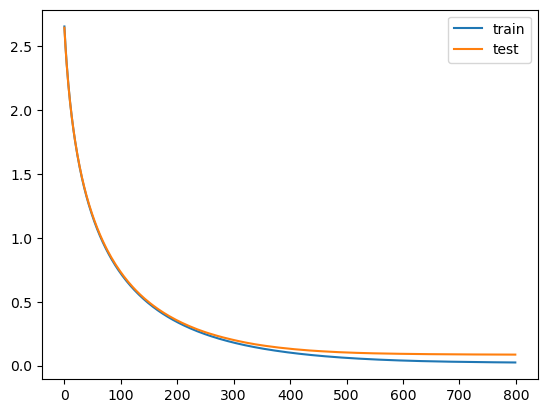

feature: 0, score: 0.00088
feature: 1, score: 0.00250
feature: 2, score: 0.00000
feature: 3, score: 0.00019
feature: 4, score: 0.00665
feature: 5, score: 0.00010
feature: 6, score: 0.00004
feature: 7, score: 0.00503
feature: 8, score: 0.14221
feature: 9, score: 0.00047
feature: 10, score: 0.00036
feature: 11, score: 0.00060
feature: 12, score: 0.00020
feature: 13, score: 0.00000
feature: 14, score: 0.00176
feature: 15, score: 0.00045
feature: 16, score: 0.03856
feature: 17, score: 0.00069
feature: 18, score: 0.12369
feature: 19, score: 0.01052
feature: 20, score: 0.00059
feature: 21, score: 0.00009
feature: 22, score: 0.00000
feature: 23, score: 0.02325
feature: 24, score: 0.00060
feature: 25, score: 0.00094
feature: 26, score: 0.00713
feature: 27, score: 0.00041
feature: 28, score: 0.00148
feature: 29, score: 0.00193
feature: 30, score: 0.00139
feature: 31, score: 0.00052
feature: 32, score: 0.00000
feature: 33, score: 0.00017
feature: 34, score: 0.02141
feature: 35, score: 0.01412
fe

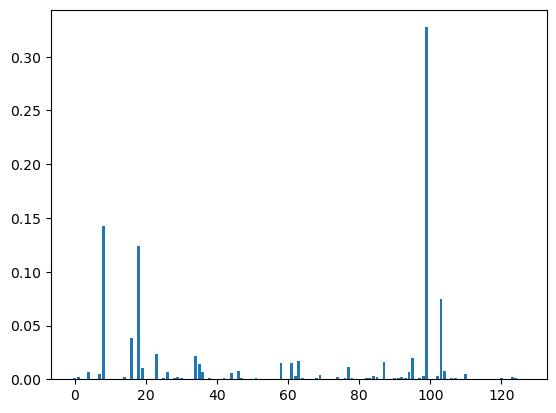

statistical analysis on the real oil price 
count    373.000000
mean      23.840607
std       11.406177
min        6.903893
25%       14.601227
50%       20.330962
75%       32.198447
max       61.564496
Name: 127, dtype: float64


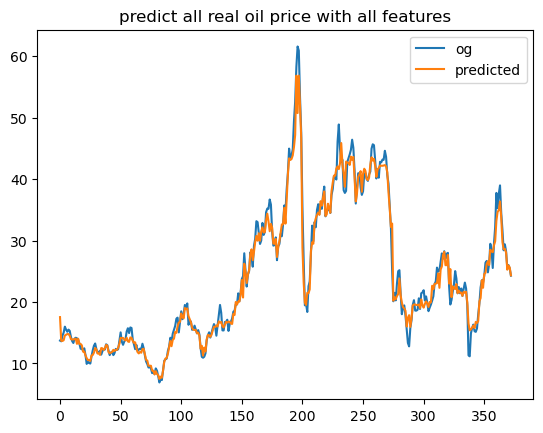

root mean square percentage error is : 7.096736484534641
percent accuracy is : 92.90326351546535


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,0,date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,Real Oil Prices
1,1,2/1/1992,12.962951297950337,12.750811646897553,5.80395026954251,19.534470895372557,17.325208817710486,5.95256421138329,6.137923565555598,6.101171002983589,...,5.861682476483604,3.5716768099709313,3.7729413378313352,3.4982508675278257,6.104336659814735,15.967271297313822,17.53375617451359,9.539484544181043,4.091742141288933,13.715728715728718
2,2,3/1/1992,12.965336258292197,12.751983327995264,5.806581842620928,19.540265979406104,17.320879858269336,5.964606564933696,6.150102669536802,6.113979644314562,...,5.86596828884247,3.575312330687437,3.782408564927373,3.5008020530571575,6.247927513443585,15.94288099715904,17.542366508430952,9.549874941837809,4.019942047145399,13.601725377426312
3,3,4/1/1992,12.970717971198013,12.75595159817002,5.807792816589388,19.5498483698075,17.329559863141757,5.9757035480077665,6.16090809039692,6.124948426681075,...,5.871375485026214,3.5801454844233804,3.7834566543602395,3.5058909297299574,6.270528942380718,15.972082308562456,17.542546750962646,9.56221265401625,4.016897408951772,14.512195121951219
4,4,5/1/1992,12.978405873890127,12.763876285390722,5.815216759804336,19.53724138617796,17.337447686605344,5.98038867100036,6.168790436835352,6.133329249606246,...,5.873099547182741,3.581351247168777,3.7834566543602395,3.5096958419333872,6.307428525192248,15.924905266508297,17.543025323519895,9.580476981214332,3.8804896266878193,15.017895490336436


In [28]:
from sklearn.calibration import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as pyplot 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


#define dataset
dataset = normalized_table.iloc[1:]

#removing index num in table (idk it was added)
dataset = dataset.iloc[: , 1:]


#instantiate labelencoder
label_encoder = LabelEncoder()





#cant have strings so its converted to a category
dataset.iloc[:, 0] = label_encoder.fit_transform(dataset.iloc[:, 0])
#converted data to a float
dataset.iloc[:, 1:] = dataset.iloc[:, 1:].astype(float)




#getting all but last column, last column is the real oil price
X = dataset.iloc[:, :-1]
#getting last column (real oil price)
y = dataset.iloc[:, -1 ]


#get half of X ( in terms of columns)

#get half of y ( in terms of rows)


#split data to X and y
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= .5 )
# so it uses one year for train and another year for test 


regressor = xgb.XGBRegressor()


#set up seach grid
#param_grid = { "n_estimators": [500, 600, 700],
#                "max_depth": [4,5,6],
#                "learning_rate": [0.01,0.015]}

#try every combo of the values above
#search = GridSearchCV(regressor,param_grid, cv = 5).fit(X,y)

#print("the best hyperparameters are ", search.best_params_)
#'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700

regressor= xgb.XGBRegressor(n_estimators = 800,
                            max_depth    = 4,
                            learning_rate = 0.006,
                            )

evalset = [(X_train,y_train), (X_test,y_test)]

regressor.fit(X_train,y_train, eval_metric = 'rmsle',eval_set = evalset)
yhat = regressor.predict(X_test)

print('actual prices')
print(y_test)
print('predicted: ')
print(yhat)




# evaluate predictions
from sklearn.metrics import mean_squared_log_error
rmse = np.sqrt(mean_squared_log_error(y_test, yhat))
print("mean squared error: %.5f" % rmse)



# retrieve performance metrics
results = regressor.evals_result()
#plot learning curve
pyplot.plot(results['validation_0']['rmsle'],label = 'train')
pyplot.plot(results['validation_1']['rmsle'], label = 'test')
#show legend
pyplot.legend()
#show the plot
pyplot.show()

"""
# graphing original vs predicted 
x_ax = range(len(y_test))
plt.plot(x_ax,y_test, label = "original")
plt.plot(x_ax, yhat , label  = "predicted")
plt.title("real oil prices vs predicted real oil prices")
plt.legend()
plt.show()
"""


#get importance
importance = regressor.feature_importances_
for i , v in enumerate(importance):
    print('feature: %0d, score: %.5f' % (i,v))
#plot feature importance
pyplot.bar([x for x in range(len(importance))],importance)
pyplot.show()


#statistical analysis on the real oil price
print("statistical analysis on the real oil price \n" + str(y.describe()))

#inputting all data to predict all real oil prices w the pretrained model
predict_w_pretrained_model = regressor.predict(X)
x_axis = range(len(y))
pyplot.plot(x_axis, y, label = "og")
pyplot.plot(x_axis, predict_w_pretrained_model, label = "predicted")
pyplot.title("predict all real oil price with all features")
pyplot.legend()
pyplot.show()

rmspe = np.sqrt(np.mean(np.square(((y-predict_w_pretrained_model)/ y)), axis = 0 ))
print("root mean square percentage error is : " + str(rmspe*100))
print("percent accuracy is : "+ str(100-(rmspe*100)))

normalized_table.head()


In [ ]:
'''
get requirements
    - how do you want to interface the data
    - prototype is this what you want
    -view data, shows all data like feature imporatnce 

'''

#if col contains > 70% negs or zeros drop col
#after that drop rows that contains negs or zeros 
#also prints list of col that has zeros or negs
def drop_col_with_negs_and_zeros(table,percent_of_negs_and_zeros):
    array_data = table.to_numpy()

    total_rows, total_cols = array_data.shape

    #skips 0 bc thats name of cols
    for row in range(1,total_rows):

        #skips 0 bc that is all dates
        for col in range(1,total_cols):
            #if count of negs and zeros > 70% of total col length then drop col
            total_length_of_col = len(table[col])







def get_col_name_from_index(col_index):
    #makes col names into a dictionary
    list_of_col_names = list(normalized_table.loc[0])
    hashmap_of_col_names_with_index_as_keys = defaultdict() 

    for i, x in enumerate(list_of_col_names):
        hashmap_of_col_names_with_index_as_keys[i] = x 

    return hashmap_of_col_names_with_index_as_keys[col_index]




def graph_each_col_with_negs_and_zeros(table):
    array_data = table.to_numpy()
    total_rows, total_cols = array_data.shape

    list_of_col_with_negs_and_zeros = set()

    #skips 0 bc thats name of cols
    for row in range(1,total_rows):
        #skips 0 bc that is all dates
        for col in range(2,total_cols):
            if float(array_data[row,col]) <= 0:
                list_of_col_with_negs_and_zeros.add(str(col)) # + ":"+str(get_col_name_from_index(col)))
                #once is finds a num <= 0, you add the col to the list
                #then use continue to go to the next col
                continue

    return(list_of_col_with_negs_and_zeros)

col_w_neg_and_zeros = graph_each_col_with_negs_and_zeros(normalized_table)
print(len(col_w_neg_and_zeros))
print(col_w_neg_and_zeros)

#to check the col for neg or zeros
#print(normalized_table.iloc[:, 74])


12
{'22', '74', '88', '89', '93', '90', '92', '70', '94', '97', '91', '100'}


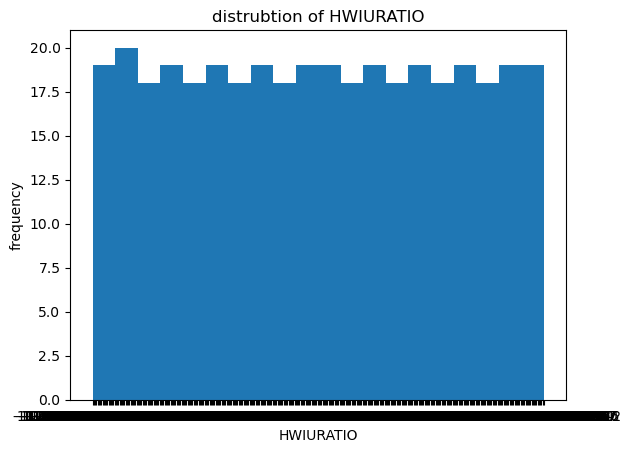

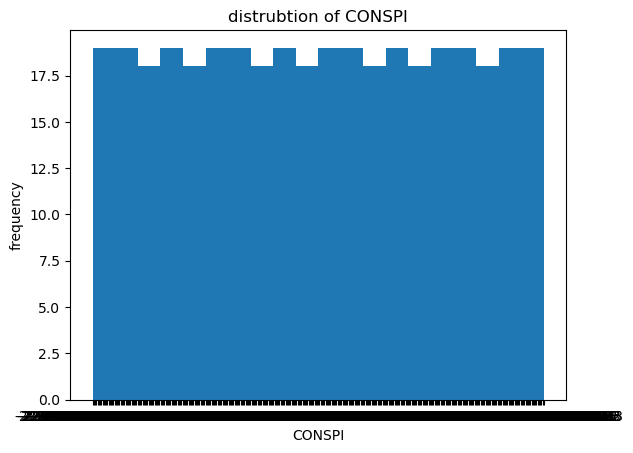

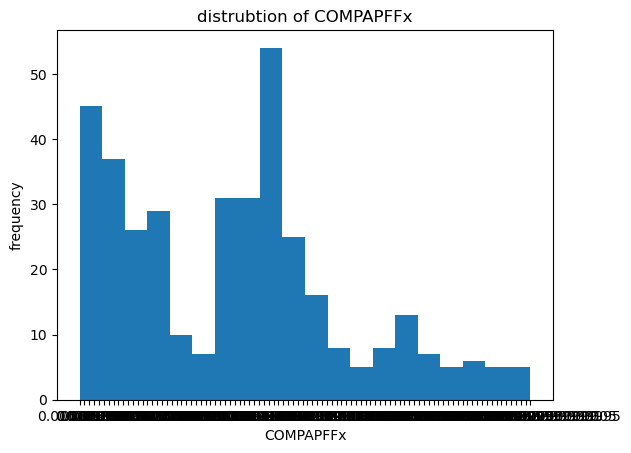

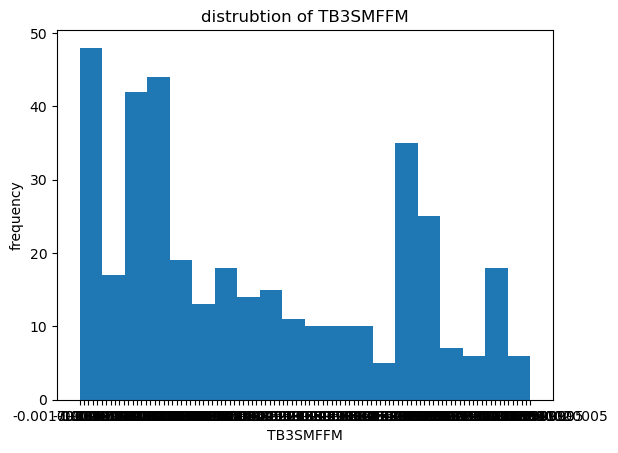

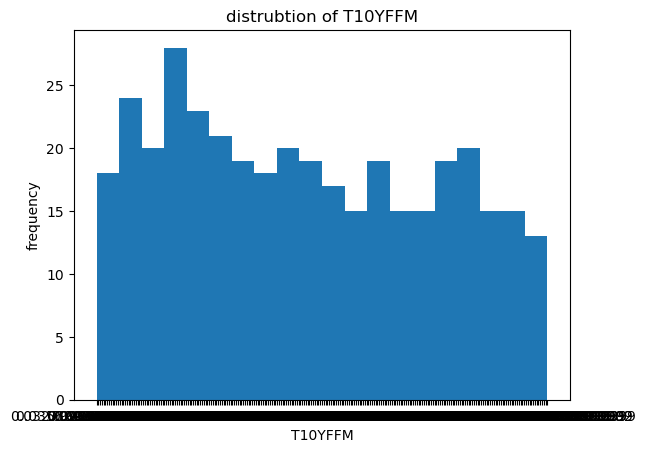

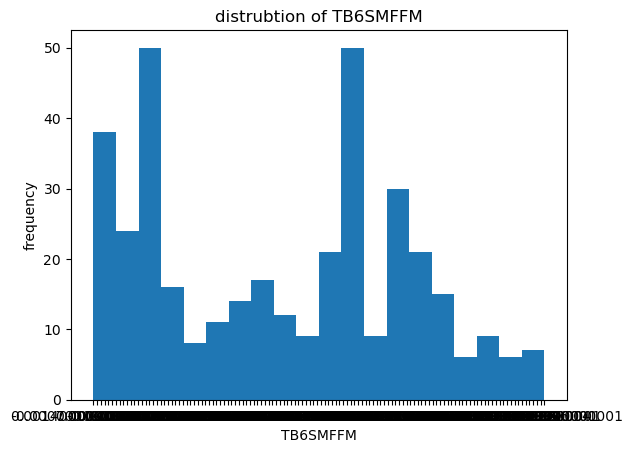

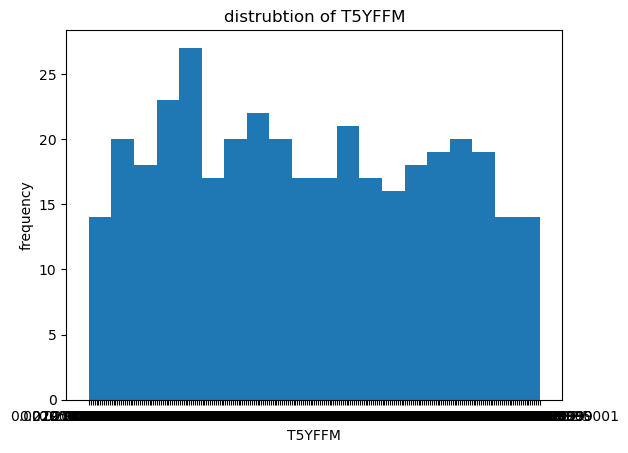

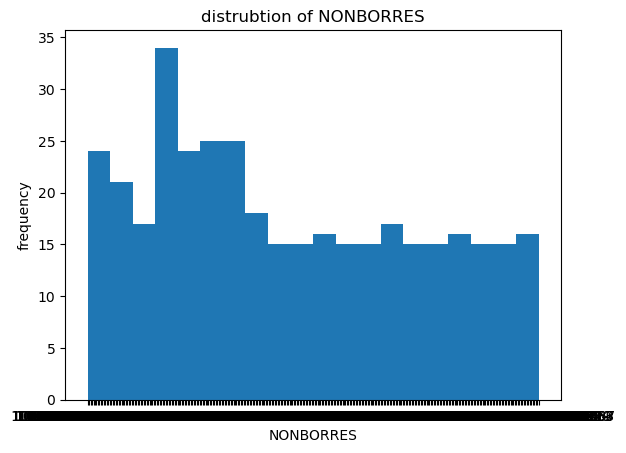

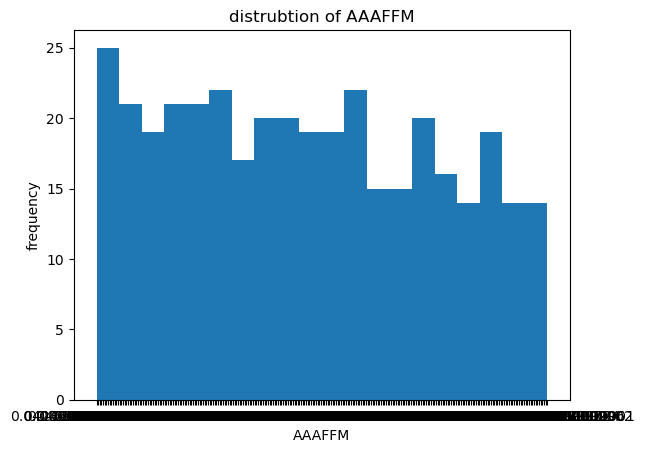

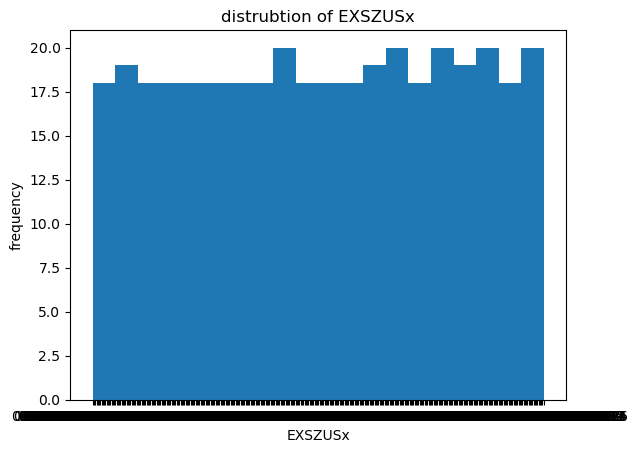

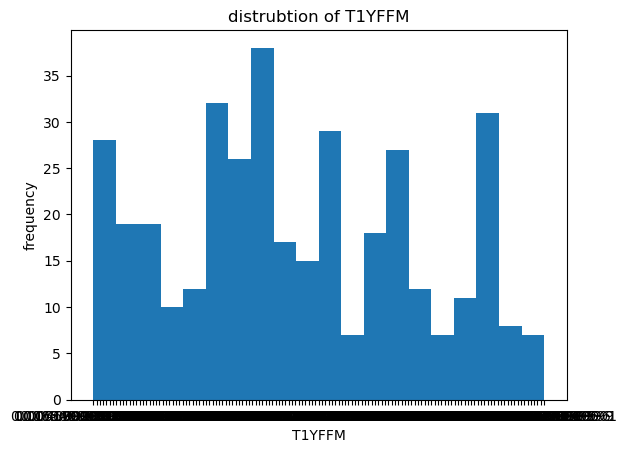

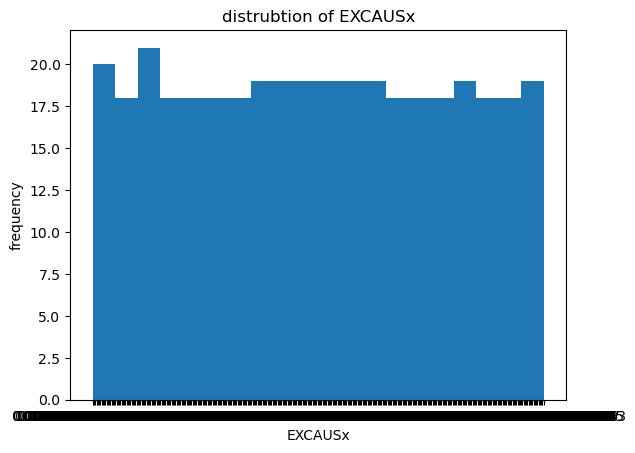

In [ ]:
#need to graph the distrubtion of col with negs or zeros
#these are columns that are log tranformed but skips zeros and negs

for col_index in (col_w_neg_and_zeros):
    column_name = (get_col_name_from_index(int(col_index)))
    data = normalized_table.iloc[:, int(col_index)][1:]

    plt.hist(data,bins =20)
    plt.xlabel(column_name)
    plt.ylabel("frequency")
    plt.title(f'distrubtion of {column_name}')
    plt.show()

#use col w no log 
#oil_factor_data graph ( list of indexies )
for col_index in (col_w_neg_and_zeros):
    column_name = (get_col_name_from_index(int(col_index)))
    data = oil_factors_data.iloc[:, int(col_index)][1:]

    plt.hist(data,bins =20)
    plt.xlabel(column_name)
    plt.ylabel("frequency")
    plt.title(f'distrubtion of {column_name}')
    plt.show()







In [ ]:

normalized_table.shape

(374, 129)